In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

from keras.models import Model, Sequential

2023-02-24 15:01:25.535749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

data_dir = "../0.data-download/data/"
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")

In [4]:
# drop the string values
train_df = train_init.drop(columns=["DepMap_ID", "age_and_sex"])
test_df = test_init.drop(columns=["DepMap_ID", "age_and_sex"])

In [5]:
# subsetting the genes
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis=1)
subset_test_df = test_df.filter(gene_list, axis=1)

In [6]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [7]:
# load the latent dimension dataframe

latent_df = pd.read_csv("../2.train-VAE/results/latent_df.csv")

print(latent_df.shape)

latent_df.head(5)

(884, 101)


,DepMap_ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,ACH-000438,-0.366216,0.366764,0.023161,0.820144,-1.270948,-0.086733,-1.396885,0.196348,0.503913,...,0.354352,1.520405,0.116153,-1.497384,-0.045450,-1.351954,-0.433699,1.738801,0.454020,1.003657
1,ACH-000903,-1.373164,-0.565102,-0.494976,1.722680,-0.255840,-0.258159,-0.679059,-0.027773,-0.759461,...,0.479026,0.583630,1.194526,-0.639945,0.080747,-1.672692,1.429650,-2.839148,0.994645,1.066637
2,ACH-000271,0.525342,0.226953,0.426089,1.155439,0.329113,1.122038,0.388267,-0.120655,1.061722,...,0.540154,-1.117755,-0.006844,0.111050,-0.248132,2.390469,0.200227,0.185597,2.456011,-0.421881
3,ACH-000055,-0.635151,-2.042248,0.717198,0.262979,-0.410099,0.549809,2.151354,-0.886611,0.100390,...,1.121050,0.683431,0.053671,0.991721,-0.214476,-0.864326,0.512332,0.163883,1.430979,-1.738265
4,ACH-000757,1.017952,-0.556430,0.461341,-0.536619,-0.146383,-0.533102,0.740360,0.646794,0.748446,...,-0.356151,1.676313,0.624631,1.682499,2.343215,1.865505,0.384006,2.362560,1.060612,2.189859


In [8]:
# create a data frame of both test and train gene dependency data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["age_category", "sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    DepMap_ID=train_and_test.DepMap_ID.astype(str),
    age_category=train_and_test.age_category.astype(str),
    sex=train_and_test.sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)
metadata

,DepMap_ID,age_category,sex,train_or_test
0,ACH-000438,Adult,Male,train
1,ACH-000903,Adult,Male,train
2,ACH-000271,Adult,Male,train
3,ACH-000055,Pediatric,Male,train
4,ACH-000757,Adult,Male,train
...,...,...,...,...
879,ACH-000984,Adult,Female,test
880,ACH-000420,Adult,Male,test
881,ACH-000490,Adult,Female,test
882,ACH-000957,Adult,Female,test


In [9]:
age_category = metadata.pop("age_category")
sex = metadata.pop("sex")
train_test = metadata.pop("train_or_test")

/home/rosedoss/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


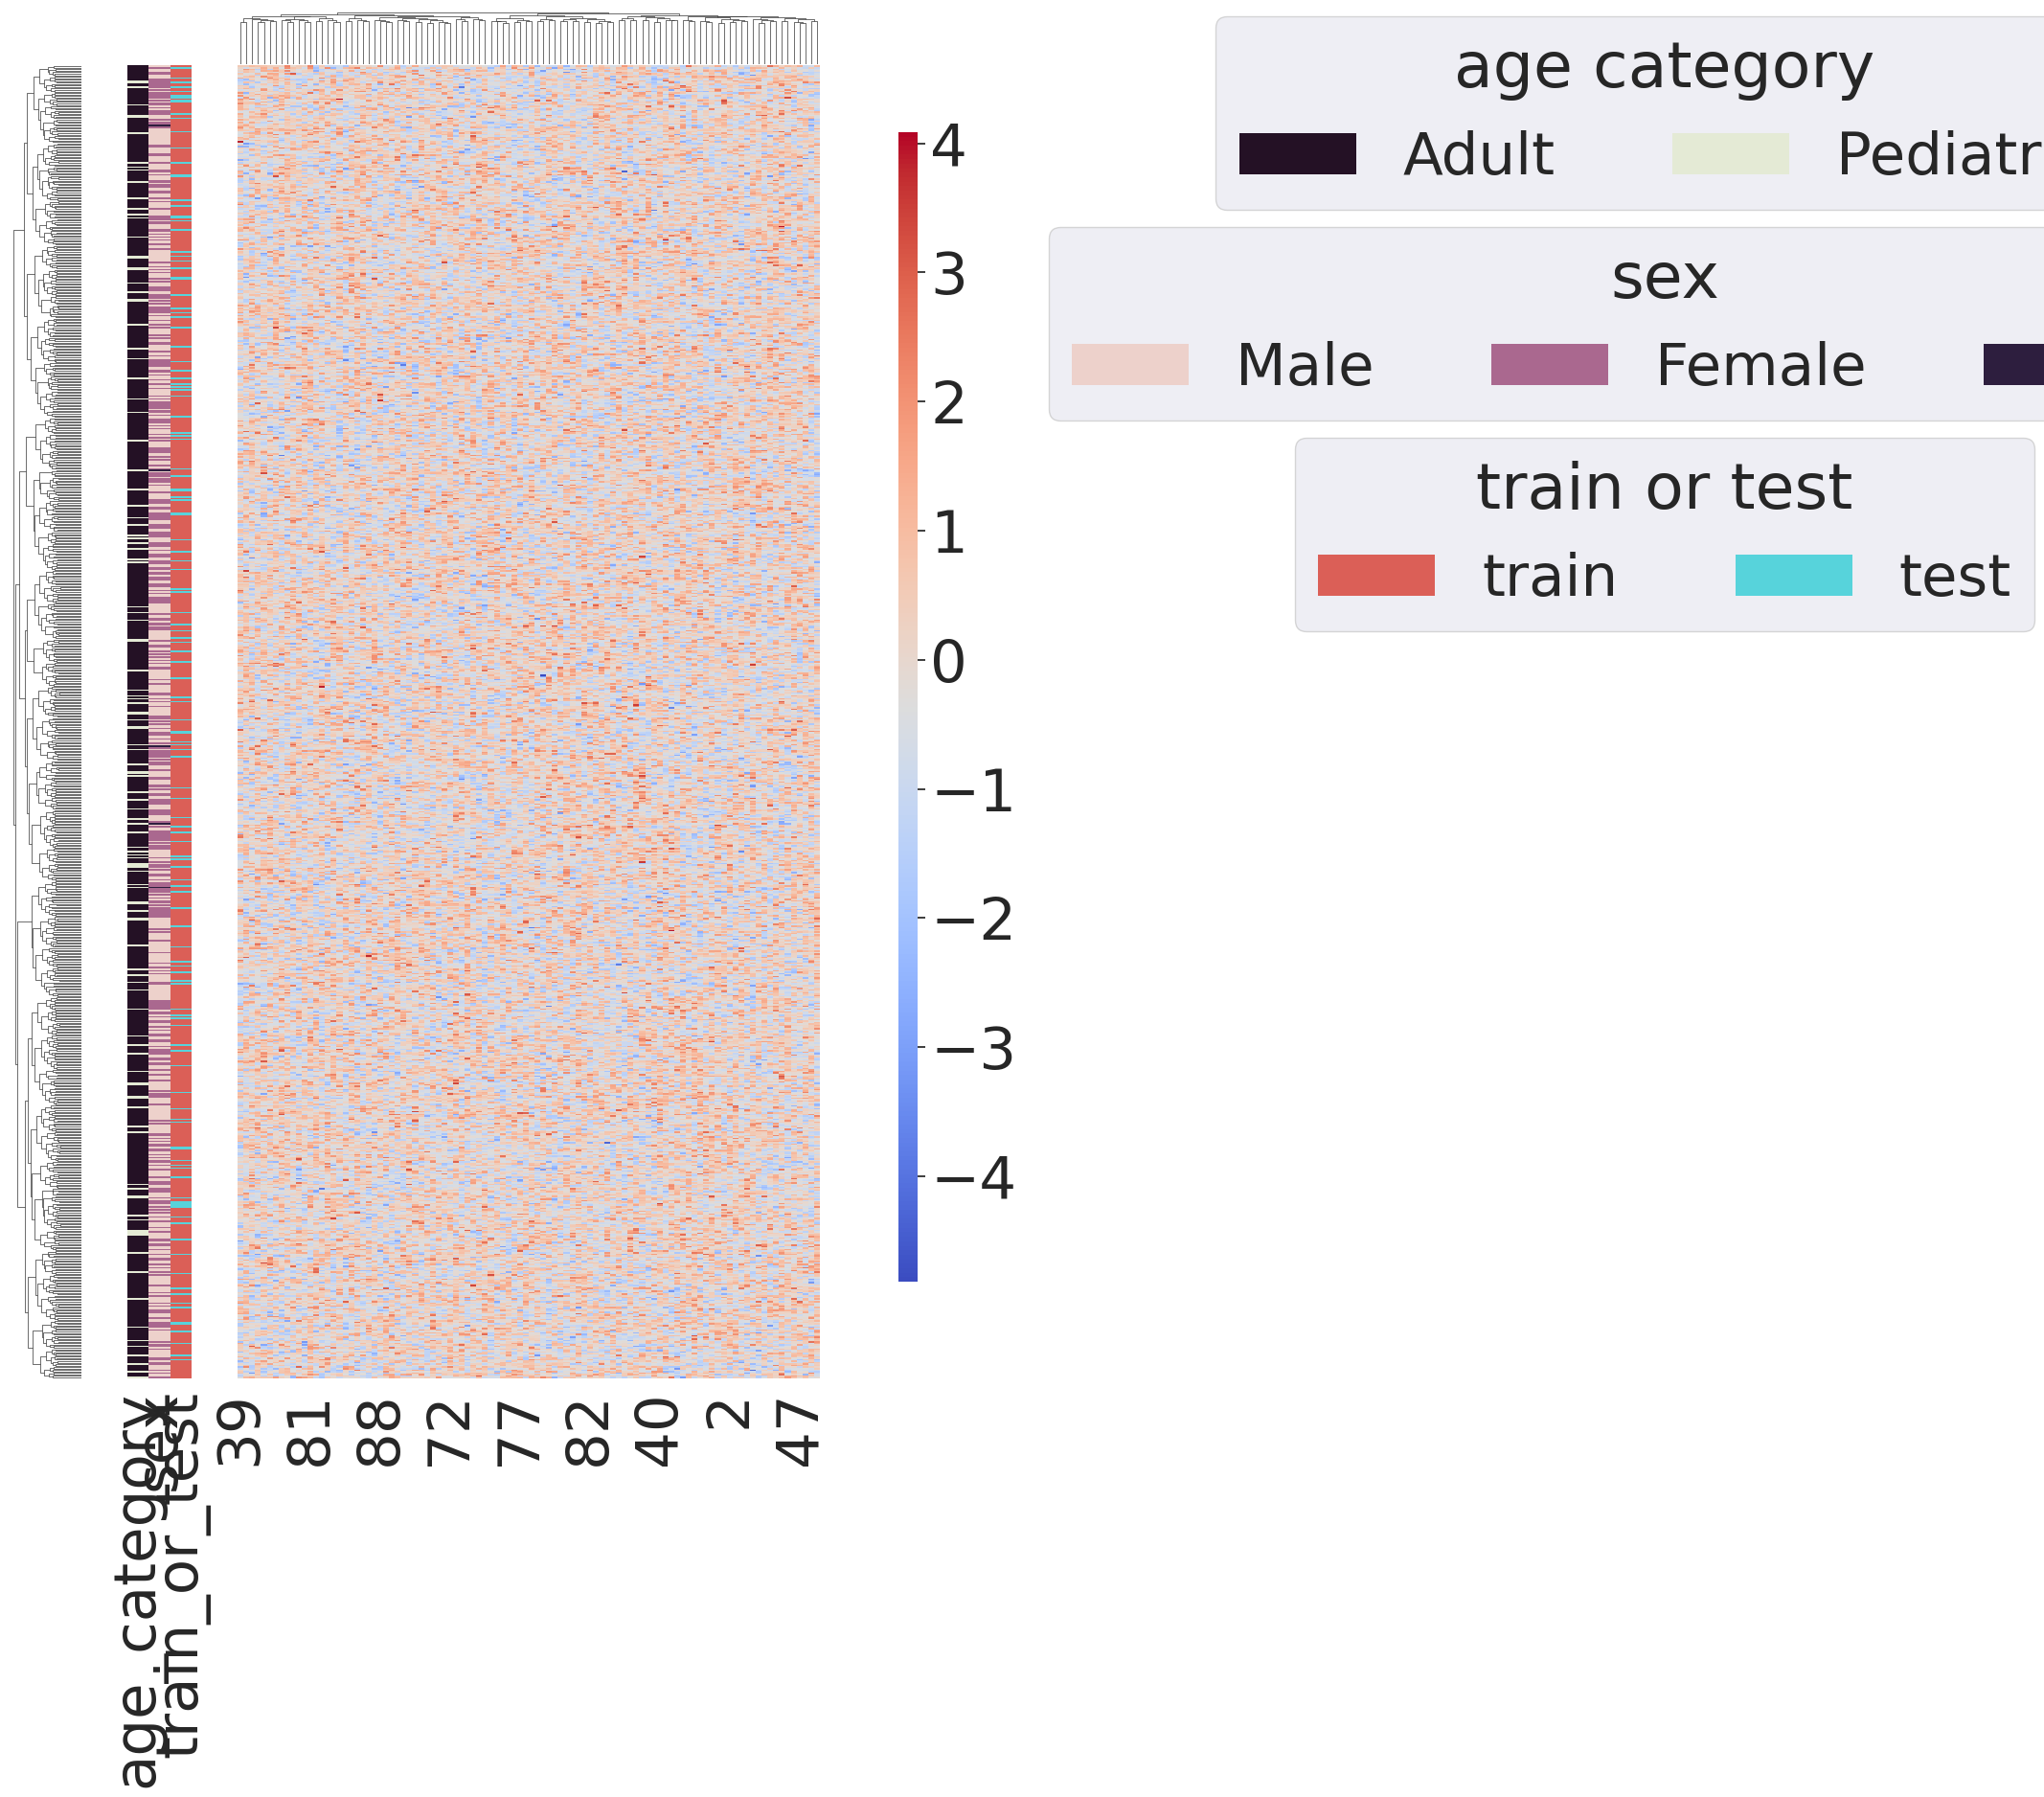

In [10]:
# display clustered heatmap of coefficients
lut_pal = sns.cubehelix_palette(
    age_category.unique().size, light=0.9, dark=0.1, reverse=True, start=1, rot=-2
)
put_pal = sns.cubehelix_palette(sex.unique().size)
mut_pal = sns.color_palette("hls", train_test.unique().size)

lut = dict(zip(age_category.unique(), lut_pal))
put = dict(zip(sex.unique(), put_pal))
mut = dict(zip(train_test.unique(), mut_pal))

row_colors1 = age_category.map(lut)
row_colors2 = sex.map(put)
row_colors3 = train_test.map(mut)

network_node_colors = pd.DataFrame(row_colors1).join(
    pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
)

sns.set(font_scale=4.0)
g = sns.clustermap(
    latent_df.iloc[:,1:],
    method="ward",
    figsize=(10, 20),
    row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
g.ax_row_dendrogram.set_visible(True)
g.ax_col_dendrogram.set_visible(True)


xx = []
for label in age_category.unique():
    x = g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
    xx.append(x)
# add the legend
legend3 = plt.legend(
    xx,
    age_category.unique(),
    loc="center",
    title="age category",
    ncol=2,
    bbox_to_anchor=(1.8, 0.91),
    bbox_transform=gcf().transFigure,
)


yy = []
for label in sex.unique():
    y = g.ax_row_dendrogram.bar(0, 0, color=put[label], label=label, linewidth=0)
    yy.append(y)
# add the second legend
legend4 = plt.legend(
    yy,
    sex.unique(),
    loc="center",
    title="sex",
    ncol=3,
    bbox_to_anchor=(1.8, 0.8),
    bbox_transform=gcf().transFigure,
)
plt.gca().add_artist(legend3)


zz = []
for label in train_test.unique():
    z = g.ax_row_dendrogram.bar(0, 0, color=mut[label], label=label, linewidth=0)
    zz.append(z)
# add the third legend
legend5 = plt.legend(
    zz,
    train_test.unique(),
    loc="center",
    title="train or test",
    ncol=2,
    bbox_to_anchor=(1.8, 0.69),
    bbox_transform=gcf().transFigure,
)
plt.gca().add_artist(legend4)


# save the figure
heat_save_path = pathlib.Path("../1.data-exploration/figures/heatmap.png")
plt.savefig(heat_save_path, bbox_inches="tight", dpi=600)

In [11]:
# load the weights dataframe

gene_weights_df = pd.read_csv("../2.train-VAE/results/weight_matrix_encoder.csv")

gene_weights_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.027460,-0.070779,0.001731,-0.094848,0.073441,-0.045740,-0.013464,-0.003496,-0.054087,0.114389,...,-0.001064,-0.025719,-0.051441,-0.059867,-0.047008,-0.097932,0.047892,-0.098538,-0.076435,-0.097514
1,0.002897,-0.163369,-0.048610,0.013512,0.006774,-0.013377,-0.061763,0.044270,-0.067225,-0.024671,...,-0.032070,-0.011596,0.032896,0.024067,-0.014068,-0.109819,-0.040015,-0.151256,-0.070344,-0.050638
2,0.068403,0.170713,-0.107413,-0.019957,-0.091245,-0.027354,-0.013429,-0.002953,0.020394,-0.045961,...,-0.156945,0.088128,-0.012880,-0.036969,0.005773,0.013009,-0.094061,0.222050,0.079966,0.150750
3,0.104246,0.044185,-0.065313,-0.095490,0.022715,-0.062570,0.006958,0.025696,0.023273,0.030976,...,-0.031745,0.041369,-0.015924,-0.087925,-0.021463,0.022722,-0.096038,0.010021,0.092492,0.092633
4,-0.061374,-0.073591,-0.018279,-0.016236,0.008553,-0.037758,0.008728,0.002456,-0.036165,-0.012164,...,0.097396,0.059990,0.030646,-0.013488,-0.032021,0.040819,-0.021807,-0.048628,-0.061967,-0.038415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.050109,-0.054951,-0.090503,-0.014368,-0.013339,-0.006154,0.042845,-0.032942,-0.007856,0.013888,...,0.013552,0.004357,-0.014182,0.015432,-0.055735,-0.045132,0.019716,-0.057088,0.026593,0.014476
996,0.015503,-0.003325,0.002184,0.027820,-0.018589,0.010963,-0.004306,0.040053,-0.033793,0.017210,...,-0.042435,0.094793,0.071430,-0.044584,0.048085,-0.082498,0.078781,-0.065269,-0.024541,-0.056585
997,0.014189,0.040160,0.114582,0.131570,0.056732,0.028147,-0.016235,-0.019135,-0.038281,-0.022187,...,0.003199,0.048005,0.004052,-0.010005,-0.088443,0.066635,-0.026834,0.034968,0.099646,0.014595
998,0.028657,0.059774,-0.020948,0.010482,0.085695,0.107653,0.009628,-0.032968,0.077526,-0.065123,...,0.040638,-0.040687,0.031039,0.004642,0.001710,0.068831,0.002279,0.024269,0.042866,0.018312


/home/rosedoss/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


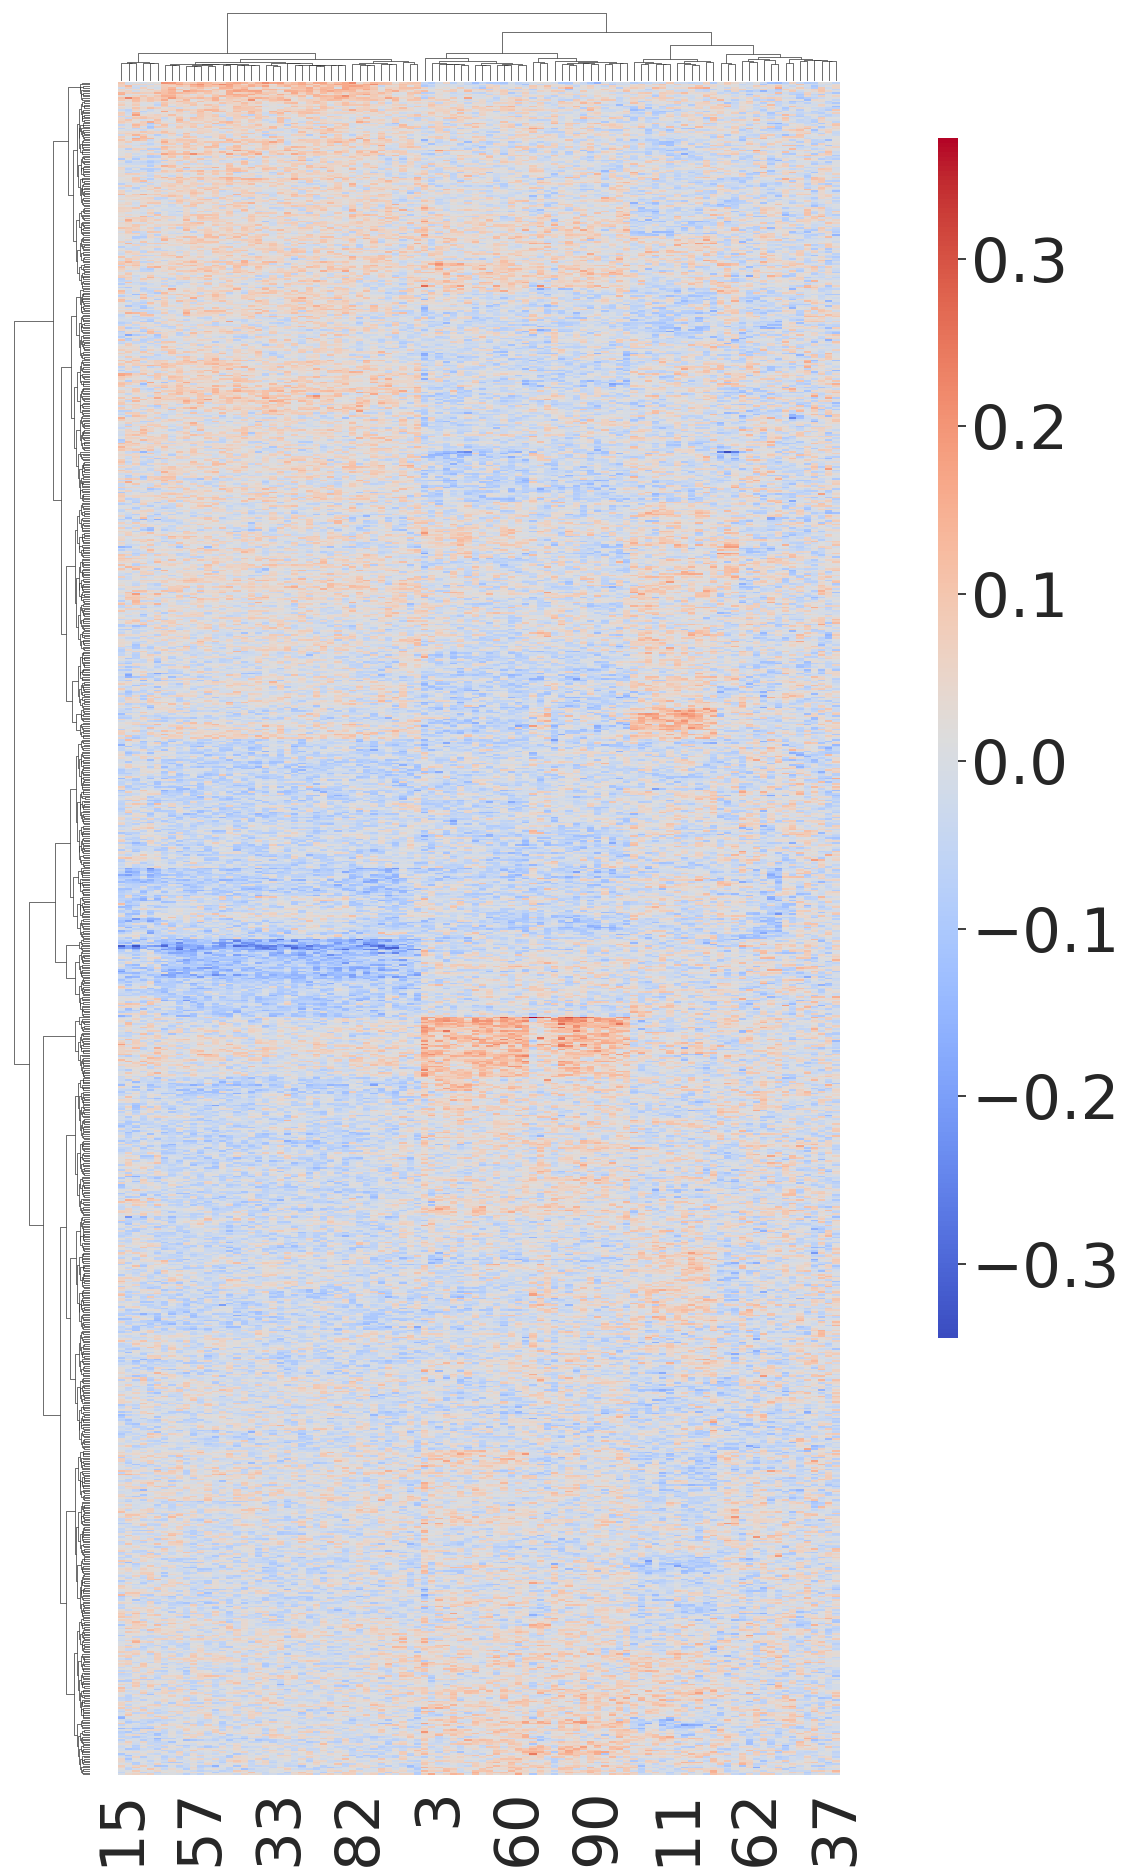

In [12]:
sns.clustermap(
    gene_weights_df,
    method="ward",
    figsize=(10, 20),
    #network_node_colors = pd.DataFrame(row_colors1).join(pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
    #row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
